## GROCERY CLASSIFER
A trained CNN that, through image recognition, will output the highest probable type of fruit or vegetable when fed with an image. A dataset of 90480 images (that can be found in this <a href="https://www.kaggle.com/datasets/moltean/fruits">link</a>) are being used to train the model.

In [55]:
# library imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import datetime

import torch
from torch.nn import functional as F
from torch import nn, optim
from torchvision import datasets, transforms, models, utils

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
print(tf.config.list_physical_devices())
print(torch.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.3.0.dev20231221


### Dataset
In this section we'll be handling the dataset and creating datasets along with data loaders.

In [56]:
data_dir = "fruits-360/"
train_dir = data_dir+"train/"
val_dir = data_dir+"test/"

In [57]:
# calculating mean and std
dataset = datasets.ImageFolder(train_dir, transform=transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
]))

loader = torch.utils.data.DataLoader(dataset, shuffle=False)

# Calculate mean and standard deviation
mean = torch.stack([torch.mean(data[0], dim=(1, 2)) for data, _ in loader]).mean(dim=0)
std = torch.stack([torch.std(data[0], dim=(1, 2)) for data, _ in loader]).mean(dim=0)

print("Mean:", mean)
print("Standard Deviation:", std)

Mean: tensor([0.6840, 0.5786, 0.5037])
Standard Deviation: tensor([0.2586, 0.3219, 0.3662])


In [120]:
batch = 128

# creating a transform object for training
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomCrop(100),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(), 
    transforms.Normalize(mean,std) 
])

# creating a dataset from folder
train_dataset = datasets.ImageFolder(train_dir, transform=transform)

# creating train loader from dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=True)

test_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.CenterCrop(100),
    transforms.ToTensor(), 
    transforms.Normalize(mean,std)
])

# creating a dataset from folder
test_dataset = datasets.ImageFolder(val_dir, transform=test_transform)

# creating train loader from dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch, shuffle=False)

### Label Mapping
In this secion we need to have a list of classes poiting to their respective names.

In [59]:
labels_list = []
for dir in os.listdir(train_dir):
    # filtering out .DS_Store folder/file
    if '.' not in dir:
        labels_list.append(dir)
# print(f'label: {label}, isDir: {os.path.isdir(label)}')
labels_list.sort()

# labels_list = []
# with open('fruits-100/classname.txt') as f:
#     for line in f:
#         labels_list.append(line.strip())
# labels_list.sort()
print(len(labels_list))
labels_list

131


['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3',
 'Apple Red Delicious',
 'Apple Red Yellow 1',
 'Apple Red Yellow 2',
 'Apricot',
 'Avocado',
 'Avocado ripe',
 'Banana',
 'Banana Lady Finger',
 'Banana Red',
 'Beetroot',
 'Blueberry',
 'Cactus fruit',
 'Cantaloupe 1',
 'Cantaloupe 2',
 'Carambula',
 'Cauliflower',
 'Cherry 1',
 'Cherry 2',
 'Cherry Rainier',
 'Cherry Wax Black',
 'Cherry Wax Red',
 'Cherry Wax Yellow',
 'Chestnut',
 'Clementine',
 'Cocos',
 'Corn',
 'Corn Husk',
 'Cucumber Ripe',
 'Cucumber Ripe 2',
 'Dates',
 'Eggplant',
 'Fig',
 'Ginger Root',
 'Granadilla',
 'Grape Blue',
 'Grape Pink',
 'Grape White',
 'Grape White 2',
 'Grape White 3',
 'Grape White 4',
 'Grapefruit Pink',
 'Grapefruit White',
 'Guava',
 'Hazelnut',
 'Huckleberry',
 'Kaki',
 'Kiwi',
 'Kohlrabi',
 'Kumquats',
 'Lemon',
 'Lemon Meyer',
 'Limes',
 'Lychee',
 'M

### Analyzing image assets
It's important to verify the image dataset the model will be working with. Things such as size and type are good indicators to drive the way the CNN will be architected

In [60]:
# checking image type and size from train dataset
images, labels = next(iter(train_loader))
img_val = images[0]
lb_val = labels[0]
print(type(img_val))
print(img_val.shape)
print(lb_val)

<class 'torch.Tensor'>
torch.Size([3, 100, 100])
tensor(16)


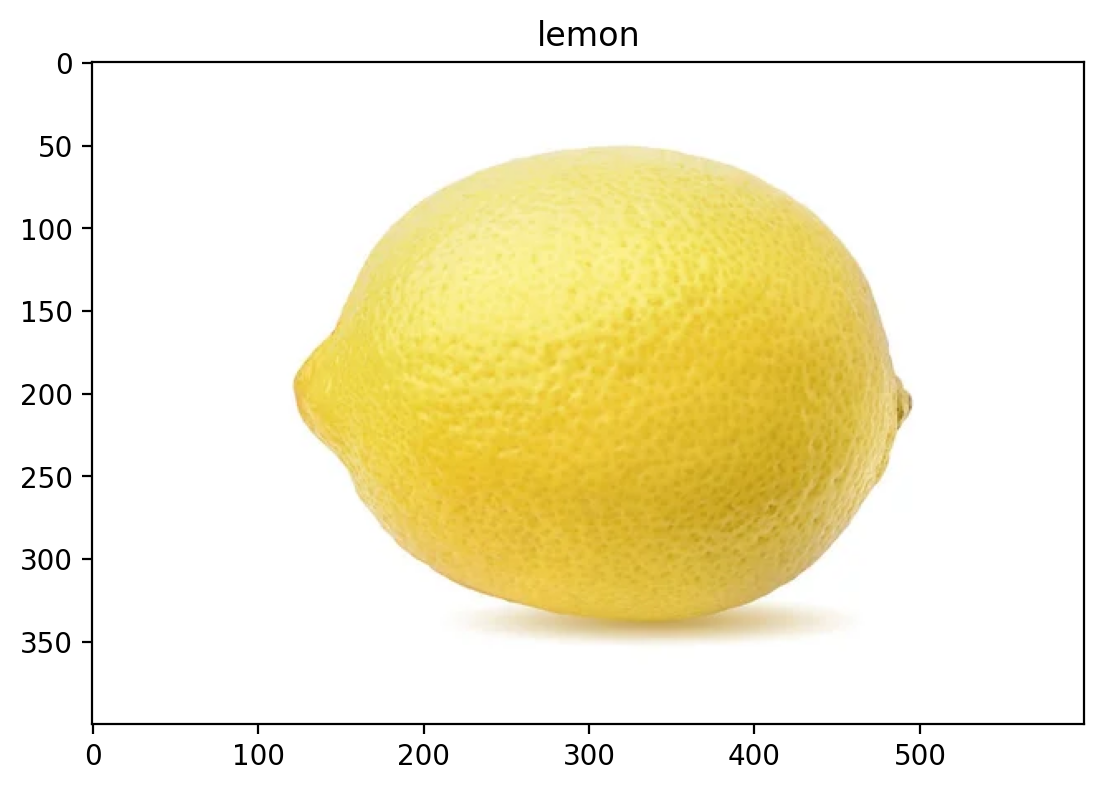

In [110]:
# plotting image from dataset
# test_img_path = val_dir+'Watermelon/125_100.jpg'
test_img_path = 'lemon01.jpg'
img = Image.open(test_img_path)
# lbl_origin = test_img_path.split('/')[2]
lbl_origin = 'lemon'
plt.title(lbl_origin)
plt.imshow(img);

### CNN
Now we need to create a network in order to train the model using the dataset

In [62]:
# create resenet model instance
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# freeze initial layers except last
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features,512),
    nn.ReLU(),
    nn.Linear(512,len(labels_list))
)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Training Network
The next step is to train the network using the chosen architecture.

In [121]:
train_losses = []
test_losses = []
def train_model(model):
    epochs = 25
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    running_loss = 0
    
    # tracking start time
    print(f'starting time: {datetime.datetime.now()}')
    
    # setting up gpu in tensorflow
    with tf.device('/GPU:0'):
        for e in range(epochs):
            # training CNN
            model.train()
            for images, labels in train_loader:
                # zeroing out gradients
                optimizer.zero_grad()
    
                # forward pass
                output = model(images)
                loss = criterion(output, labels)
    
                running_loss += loss.item()
    
                # backwards and optmizing
                loss.backward()
                optimizer.step()
            
            scheduler.step()
            
            # else:
            # validating CNN
            test_loss = 0
            accuracy = 0
            total = 0
            correct = 0
            model.eval()
            with torch.no_grad():
                for images, labels in test_loader:
                    # forward pass
                    test_ps = model(images)

                    t_loss = criterion(test_ps, labels)
                    test_loss += t_loss.item()

                    # calculate accuracy
                    _, predicted = torch.max(test_ps.data, dim=1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))

            accuracy = 100 * correct / total

            print(f'epoch: {e+1}/{epochs}; '
                  f'running loss: {running_loss/len(train_loader):.3f}; '
                  f'test loss: {test_loss/len(test_loader):.3f}; '
                  f'accuracy: {accuracy:.3f}% '
                  f'timestamp: {datetime.datetime.now()} ')
                  # f'accuracy: {accuracy/len(test_loader):.3f}; ')

            # resetting running loss
            running_loss = 0

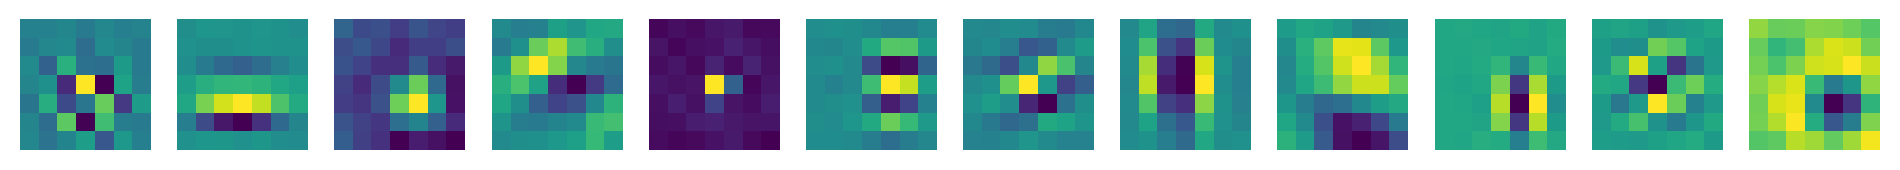

In [111]:
def plot_cnn_filter(layer, num_filters):
    """visualizing conv layer filter"""

    # Get the weights of the layer
    filters = layer.weight.data.cpu().numpy()

    #check size for sanity check
    # print(filters)

    # Normalize the filters to the range [0, 1] so that matplotlib can plot them
    filters = (filters - filters.min()) / (filters.max() - filters.min())
    
    # Plot the filters
    num_filters = min(num_filters, filters.shape[0])
    fig, axes = plt.subplots(1, num_filters, figsize=(num_filters, 1))
    for i in range(num_filters):
        ax = axes[i]
        # If the filter has multiple channels (e.g., RGB), select the first channel
        filter_img = filters[i, 0, :, :]
        ax.imshow(filter_img, cmap='viridis')
        ax.axis('off')
    plt.show()
    

plot_cnn_filter(saved_model.conv1, 12)

### Analyzing model training performance
Plotting the train and validation losses is a good way to gauge how well the model has performed

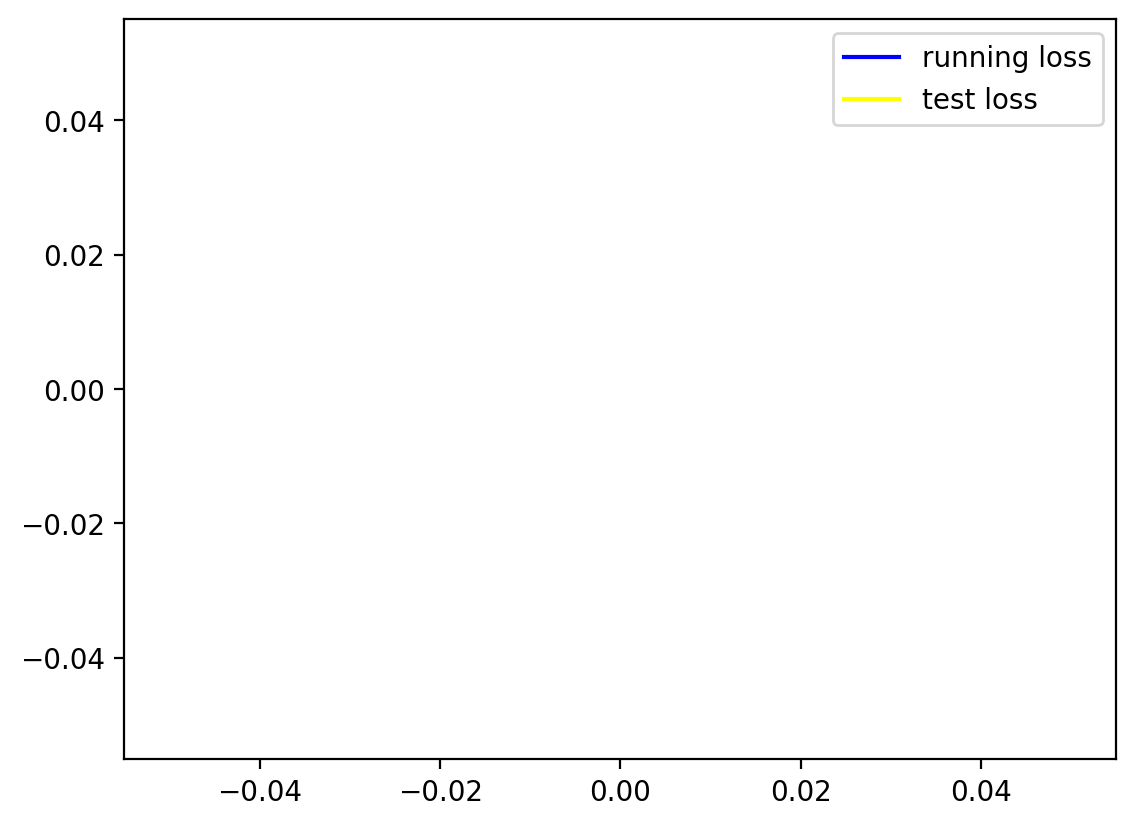

In [112]:
# plotting loss difference
fig, ax = plt.subplots()
ax.plot(train_losses, color = 'blue', label = 'running loss')
ax.plot(test_losses, color = 'yellow', label = 'test loss')
ax.legend()
plt.show()

### Saving model for later use
Saving trained model for later use or transfered learning

In [66]:
checkpoint_dict = {
    'epochs': epochs,
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'criterion': criterion.state_dict()
}
torch.save(checkpoint_dict, 'checkpoint.pth')

### Processing and predicting image
Now that the CNN has been trained we can use the model to predict an image as input

In [115]:
# preprocess image before verifying
def preprocess_image(image_path):
    # image = transforms.ToPILImage()(image_path)
    
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.CenterCrop(100),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    image = transform(image).unsqueeze(0)
    
    return image

In [116]:
# test the model using a random image
def predict(image_path):
    model.eval()
    with torch.no_grad():
        processed_image = preprocess_image(image_path)
        outputs = saved_model(processed_image)
        # print(f'raw output tensor: {outputs}; tensor size: {len(outputs[0])}')
        
        topk_probs, topk_classes = torch.topk(F.softmax(outputs, dim=1), k=5)
        # print(f'topk probs: {topk_probs}')
        # print(f'topk classes: {topk_classes}')
        
    return topk_probs[0], topk_classes[0]

In [117]:
probs, preds = predict(test_img_path)
print(f'probabilities: {probs}')
print(f'predictions: {preds}')

probabilities: tensor([0.4391, 0.4000, 0.0293, 0.0267, 0.0264])
predictions: tensor([ 60,  81,  97,  50, 106])


### Plotting prediction results
Finally, plotting the prediction output in order to put into perpective the results the model is processing using a random image from the dataset

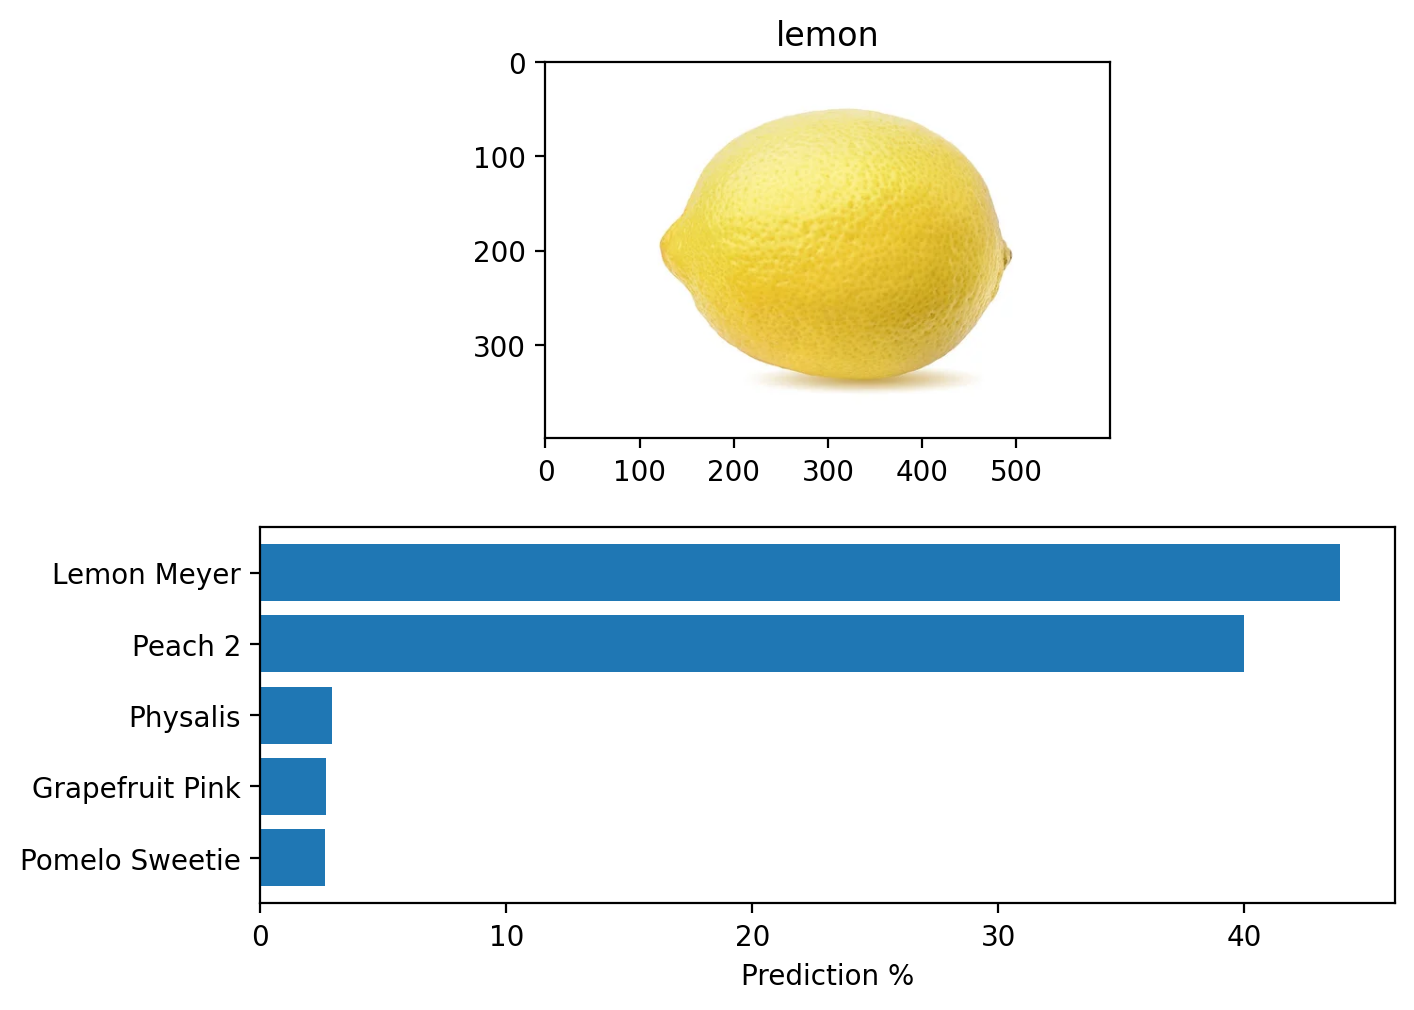

In [118]:
# plot image and chart of top k predicted values
fig, axs = plt.subplots(2)
fig.tight_layout()

axs[0].set_title(lbl_origin)
axs[0].imshow(img)

pred_labels = [labels_list[idx] for idx in preds]

y_pos = np.arange(len(probs))

# print(pred_labels)
prob_perc = [p * 100 for p in probs]
axs[1].barh(pred_labels, prob_perc)
axs[1].set_yticks(y_pos, labels=pred_labels)
axs[1].invert_yaxis()
axs[1].set_xlabel('Prediction %')
axs[1].plot();

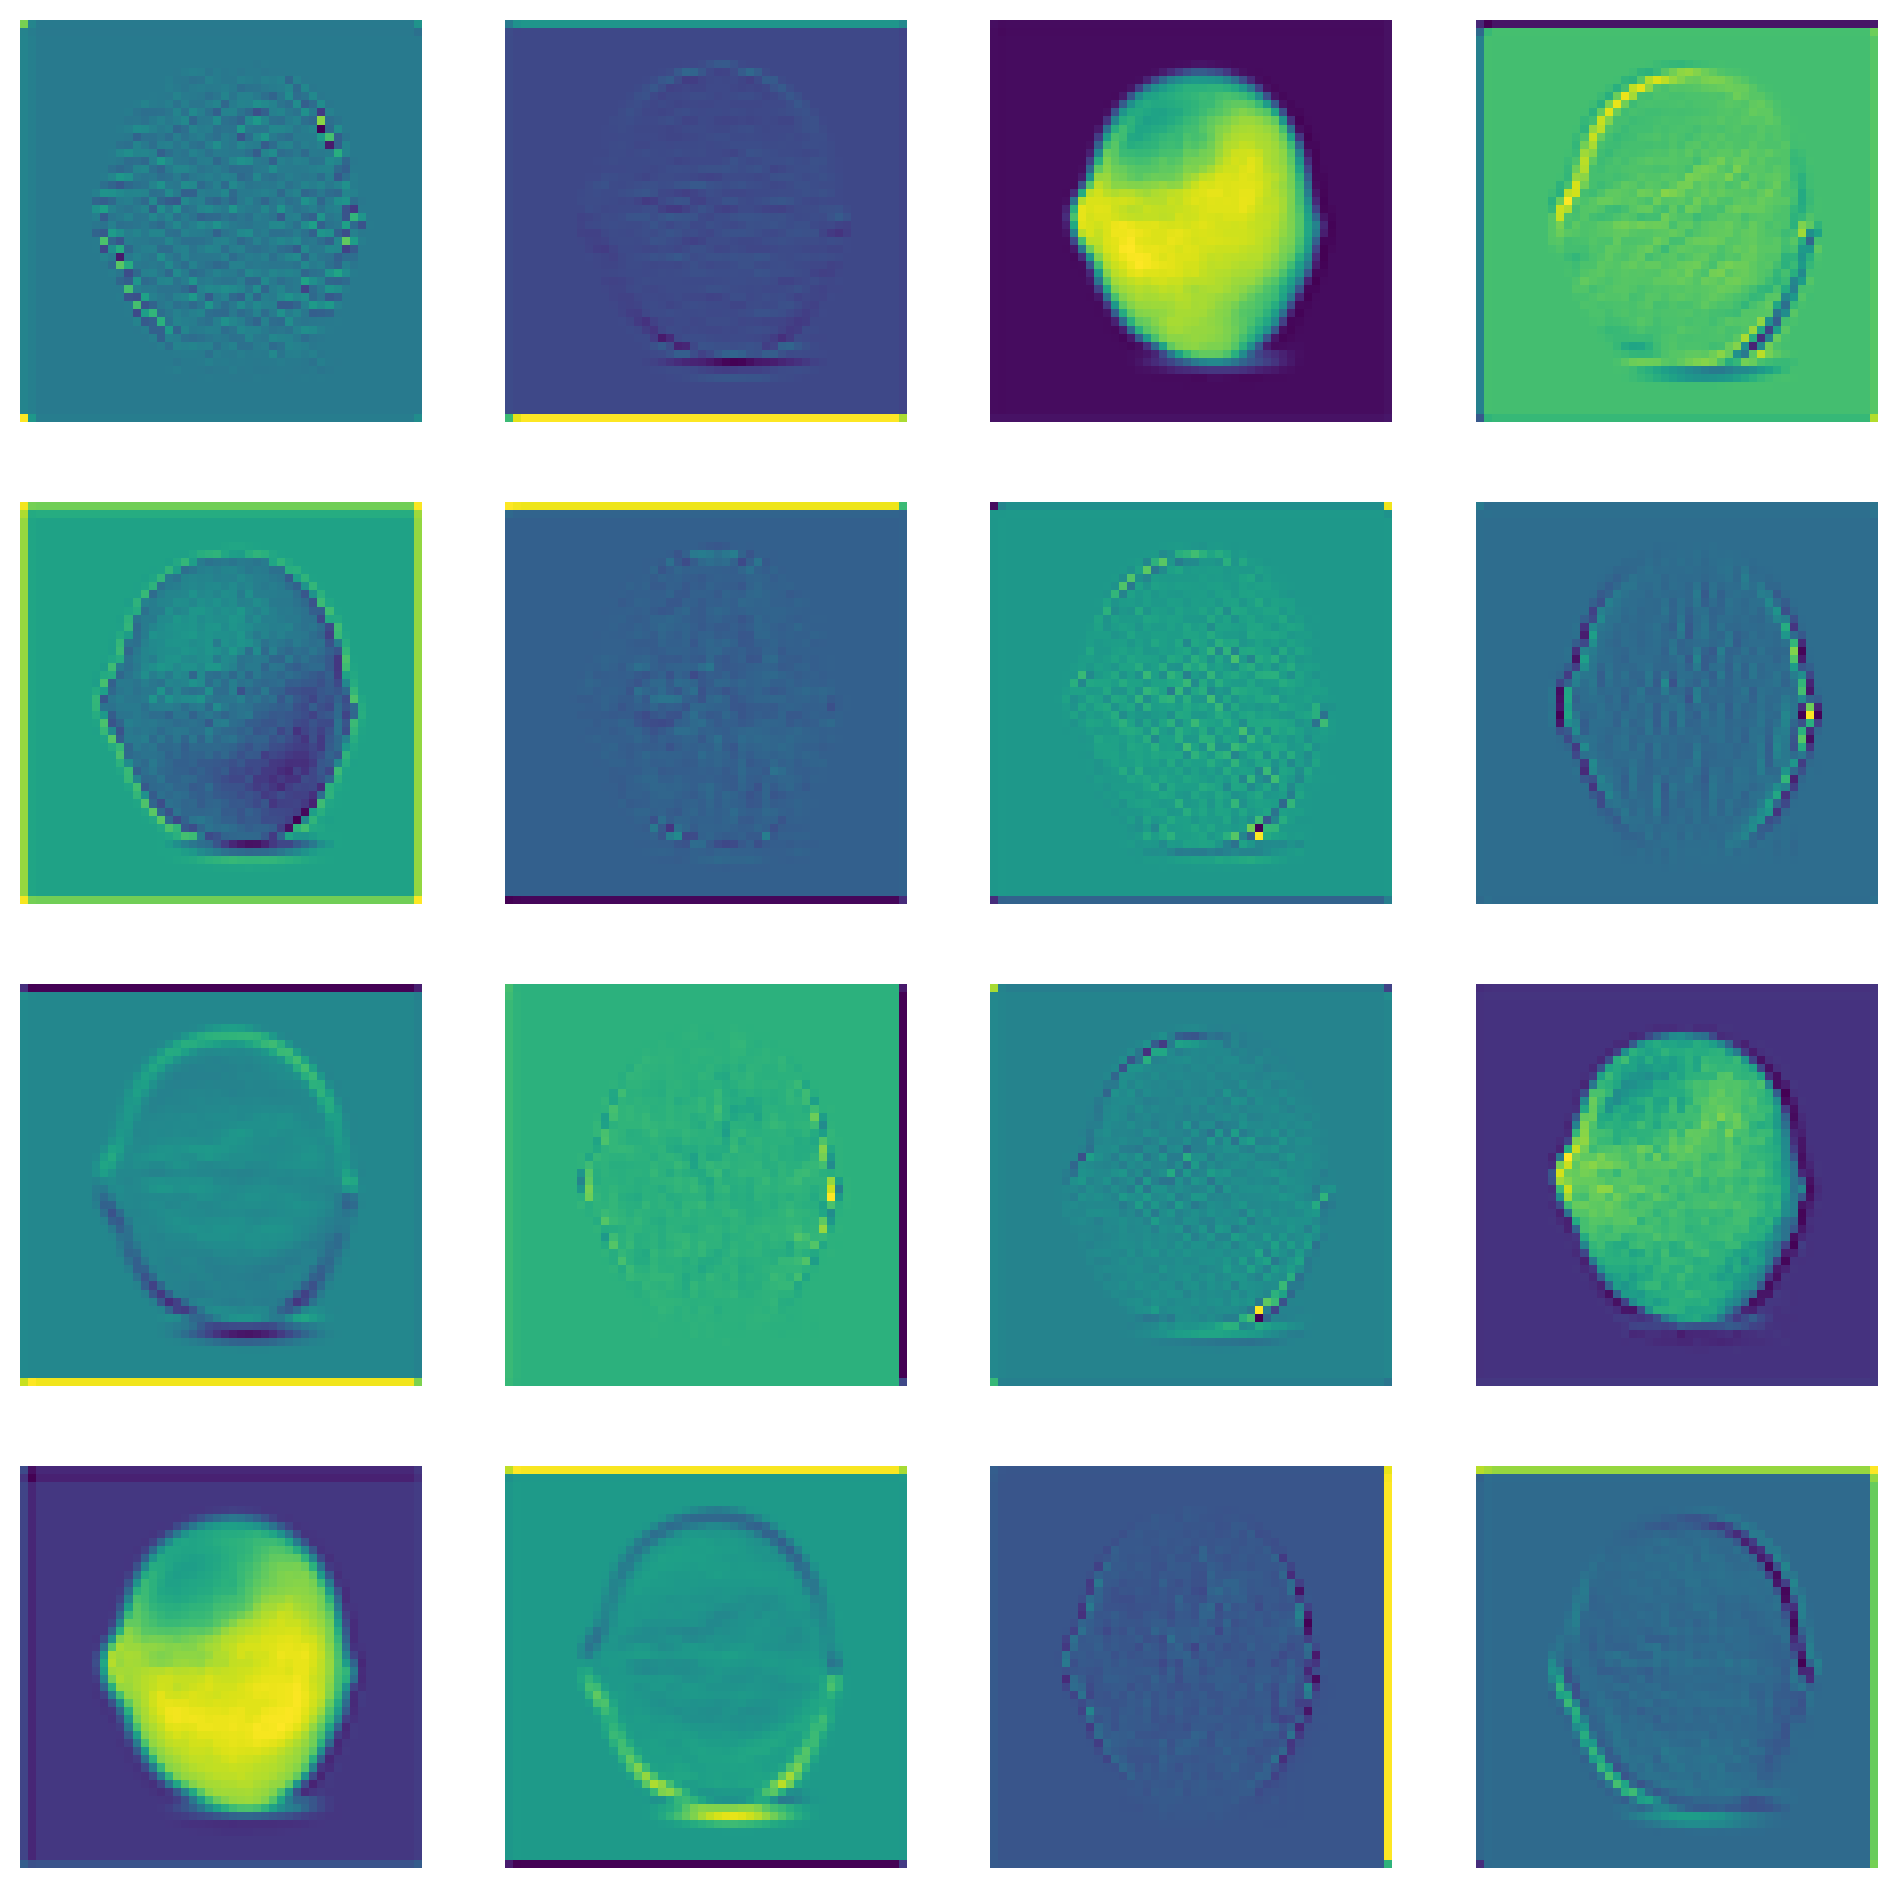

In [119]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
    
# Hook into the first conv layer
model.conv1.register_forward_hook(get_activation('conv1'))

# Get activations
# test_img_path = "/mnt/data/lemon01.jpg"
image = preprocess_image(test_img_path)
output = model(image)

# Plot the first 16 activations in the first conv layer
act = activation['conv1'].squeeze().cpu()
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    ax.imshow(act[i], cmap='viridis')
    ax.axis('off')
plt.show()

In [100]:
# create resenet model instance
saved_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
saved_model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(saved_model.fc.in_features, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, len(labels_list))
)
checkpoint = torch.load('checkpoint.pth')
pretrained_dict = {k: v for k, v in checkpoint['model'].items() if 'fc' not in k}
model_dict = saved_model.state_dict()
model_dict.update(pretrained_dict)
saved_model.load_state_dict(model_dict)

# Set new layers to require gradient updates
for param in saved_model.parameters():
    param.requires_grad = False

for param in saved_model.fc.parameters():
    param.requires_grad = True

saved_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [106]:
train_model(saved_model)

starting time: 2024-06-25 19:41:37.735515
epoch: 1/10; running loss: 1.010; test loss: 0.698; accuracy: 80.304% timestamp: 2024-06-25 21:13:38.433080 
epoch: 2/10; running loss: 0.928; test loss: 0.653; accuracy: 81.603% timestamp: 2024-06-25 22:37:09.003690 
epoch: 3/10; running loss: 0.889; test loss: 0.549; accuracy: 82.951% timestamp: 2024-06-25 23:55:12.168753 
epoch: 4/10; running loss: 0.855; test loss: 0.580; accuracy: 83.224% timestamp: 2024-06-26 01:13:20.988182 
epoch: 5/10; running loss: 0.840; test loss: 0.567; accuracy: 83.364% timestamp: 2024-06-26 02:12:37.965097 
epoch: 6/10; running loss: 0.737; test loss: 0.512; accuracy: 85.283% timestamp: 2024-06-26 03:01:13.548107 
epoch: 7/10; running loss: 0.688; test loss: 0.479; accuracy: 86.139% timestamp: 2024-06-26 03:49:30.065337 
epoch: 8/10; running loss: 0.657; test loss: 0.469; accuracy: 86.464% timestamp: 2024-06-26 04:37:38.360641 
epoch: 9/10; running loss: 0.635; test loss: 0.443; accuracy: 87.087% timestamp: 2024-